# Boat Object Detection with YOLO

In this exercise, you will fine-tune a YOLO model for boat detection in satellite imagery.

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import pandas as pd

## Data Collection

Download the training and test datasets.

In [3]:
download = 1 # Set "download = None" if you have not already downloaded the files

In [4]:
if download is None:
    # URLs for the dataset files
    data_train_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_train.pkl'
    data_train_labels_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/y_train.pkl'
    data_test_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_test.pkl'

    def download_file(url, file_name):
        response = requests.get(url)
        response.raise_for_status()
        with open(file_name, 'wb') as file:
            file.write(response.content)
        print(f'Downloaded {file_name}')

    # Download the files
    download_file(data_train_features_url, 'X_train.pkl')
    download_file(data_train_labels_url, 'y_train.pkl')
    download_file(data_test_features_url, 'X_test.pkl')

In [5]:
# Load the training data
with open('X_train.pkl', 'rb') as f:
    X = pickle.load(f)

with open('y_train.pkl', 'rb') as f:
    y = pickle.load(f)

print(f"Loaded {len(X)} training images")
print(f"Sample image shape: {X[0].shape}")
print(f"Sample labels shape: {y[0].shape}")
print(f"Sample labels (YOLO format - class_id, x_center, y_center, width, height):\n{y[0]}")

Loaded 496 training images
Sample image shape: (418, 466, 3)
Sample labels shape: (1, 5)
Sample labels (YOLO format - class_id, x_center, y_center, width, height):
[[0.       0.659871 0.57177  0.109442 0.162679]]


## Data Visualization

Display sample images with bounding boxes.

In [6]:
def plot_image_with_boxes(image, boxes, ax=None):
    """
    Plot an image with bounding boxes
    boxes: numpy array with shape (n, 5) - [class_id, x_center, y_center, width, height]
    All box coordinates are normalized (0-1)
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    ax.imshow(image)
    height, width = image.shape[:2]
    
    # Draw each bounding box
    for box in boxes:
        class_id, x_center, y_center, box_width, box_height = box
        
        # Convert from normalized YOLO format to pixel coordinates
        x_center_px = x_center * width
        y_center_px = y_center * height
        box_width_px = box_width * width
        box_height_px = box_height * height
        
        # Calculate top-left corner
        x1 = x_center_px - box_width_px / 2
        y1 = y_center_px - box_height_px / 2
        
        # Draw rectangle
        rect = patches.Rectangle(
            (x1, y1), box_width_px, box_height_px,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        ax.text(x1, y1-5, 'boat', color='red', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax.axis('off')
    return ax

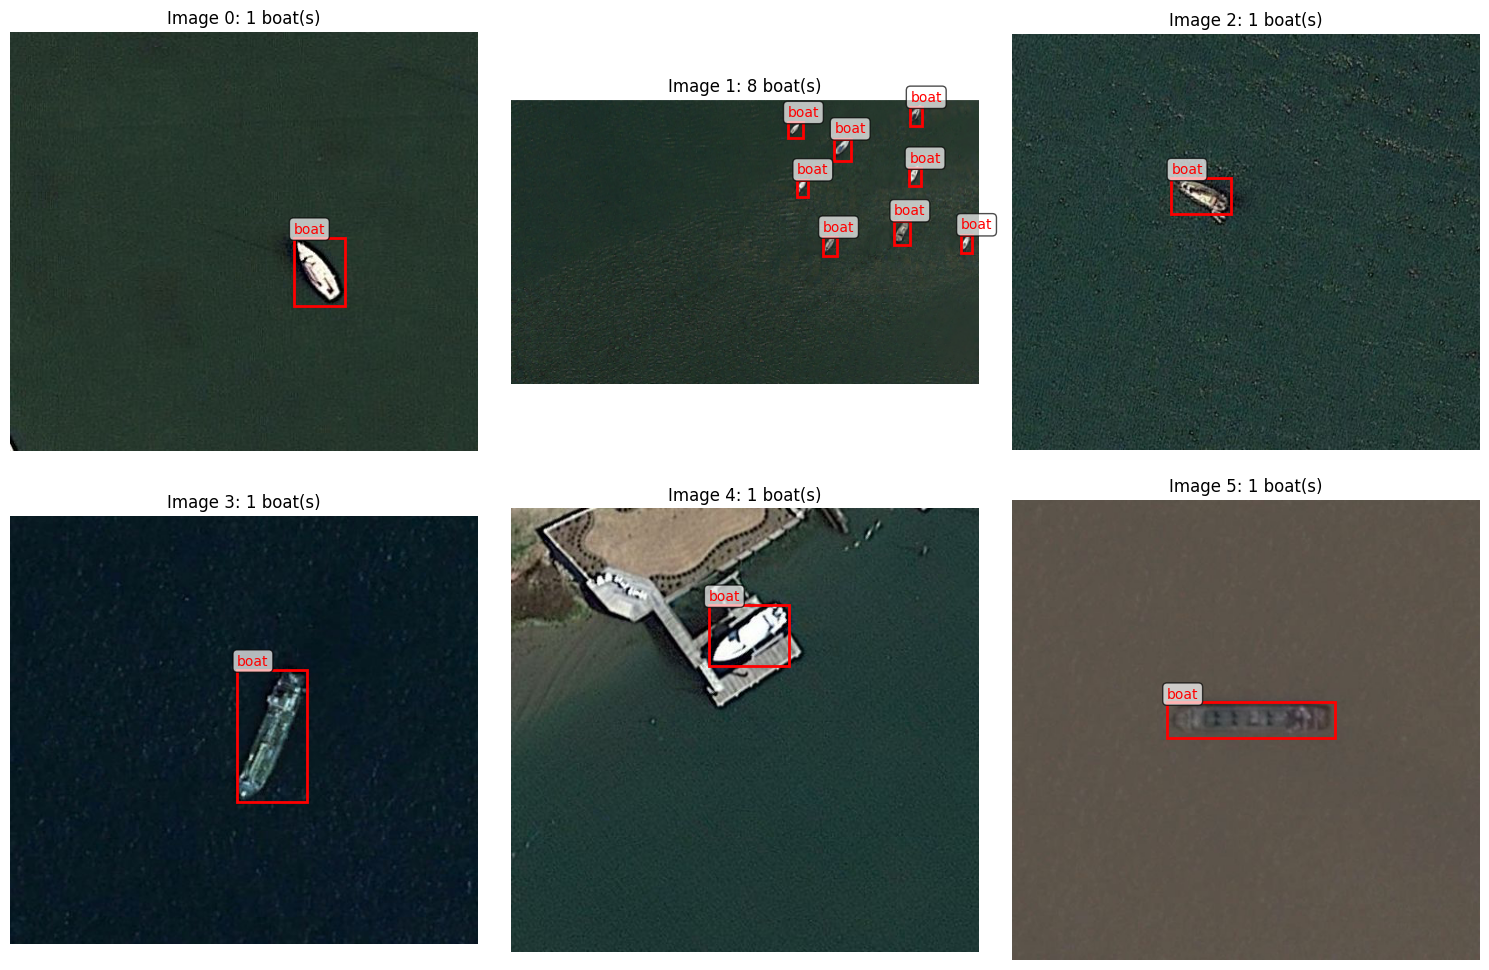

In [7]:
# Display 5 sample images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    plot_image_with_boxes(X[i], y[i], ax=axes[i])
    axes[i].set_title(f'Image {i}: {len(y[i])} boat(s)')

plt.tight_layout()
plt.show()

## Model Setup

Load a pre-trained YOLO model and test it on the training images.

In [8]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (nano version)
model = YOLO('yolov8n.pt')

print("Model loaded successfully!")

Model loaded successfully!


In [9]:
# Test the pre-trained model on a sample image
# Save a sample image temporarily
from PIL import Image
sample_img = Image.fromarray(X[0])
sample_img.save('temp_sample.png')

# Run prediction
results = model.predict(source='temp_sample.png', conf=0.25)

print(f"Pre-trained model detected {len(results[0].boxes)} objects")
print("Note: The pre-trained model may not detect boats well - you need to fine-tune it!")


image 1/1 c:\Users\tbout\Documents\Sorbonne\DataScience\RepoGnral\data_science_practice_2025\hugojava\module7\temp_sample.png: 576x640 1 tennis racket, 211.1ms
Speed: 49.4ms preprocess, 211.1ms inference, 19.3ms postprocess per image at shape (1, 3, 576, 640)
Pre-trained model detected 1 objects
Note: The pre-trained model may not detect boats well - you need to fine-tune it!


## Fine-tune your YOLO model

Your task is to fine-tune the YOLO model on the boat detection dataset to achieve a mAP50 score of at least 0.73 on the test set.

In [10]:
# Your code here
# Fine-tune the YOLO model

### Train Test Split

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(len(X_train), len(X_val))
print(len(y_train), len(y_val))

396 100
396 100


### Creation of the files to be able to use the mAP50 metric

In [12]:
import os
import cv2
import yaml
import numpy as np

# === Configurations ===
# Tes données déjà chargées :
# X_train, y_train, X_val, y_val
# y_* = liste (ou array) de listes [label, x_center, y_center, height, width]
# toutes les coordonnées sont déjà normalisées entre 0 et 1

# Noms des classes
class_names = ['boat']  # ➜ change si tu as plusieurs classes

# Dossier de sortie
base_dir = "dataset_boats"
os.makedirs(base_dir, exist_ok=True)

# Sous-dossiers
splits = {
    "train": (X_train, y_train),
    "val": (X_val, y_val)
}

# === Sauvegarde images et labels ===
for split, (X, y) in splits.items():
    img_dir = os.path.join(base_dir, split, "images")
    label_dir = os.path.join(base_dir, split, "labels")
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    print(f"\n➡️ Sauvegarde des données {split} ({len(X)} images) ...")

    for i, (img, labels) in enumerate(zip(X, y)):
        # Sauvegarde image
        img_path = os.path.join(img_dir, f"img_{i}.jpg")
        cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        # Sauvegarde labels (format YOLO)
        label_path = os.path.join(label_dir, f"img_{i}.txt")
        with open(label_path, "w") as f:
            for lab in np.atleast_2d(labels):  # gérer le cas 1 seule bbox
                cls, x, y_, h, w_ = lab
                f.write(f"{int(cls)} {x:.6f} {y_:.6f} {w_:.6f} {h:.6f}\n")

print("\n✅ Images et labels sauvegardés avec succès !")

# === Création du fichier data.yaml ===
data_yaml = {
    "train": os.path.abspath(os.path.join(base_dir, "train/images")),
    "val": os.path.abspath(os.path.join(base_dir, "val/images")),
    "nc": len(class_names),
    "names": class_names
}

yaml_path = os.path.join(base_dir, "data.yaml")
with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"\n✅ Fichier data.yaml créé : {yaml_path}")
print("\nContenu du fichier :")
print(yaml.dump(data_yaml, default_flow_style=False))


➡️ Sauvegarde des données train (396 images) ...

➡️ Sauvegarde des données val (100 images) ...

✅ Images et labels sauvegardés avec succès !

✅ Fichier data.yaml créé : dataset_boats\data.yaml

Contenu du fichier :
names:
- boat
nc: 1
train: "c:\\Users\\tbout\\Documents\\Sorbonne\\DataScience\\RepoG\xE9n\xE9ral\\data_science_practice_2025\\\
  hugojava\\module7\\dataset_boats\\train\\images"
val: "c:\\Users\\tbout\\Documents\\Sorbonne\\DataScience\\RepoG\xE9n\xE9ral\\data_science_practice_2025\\\
  hugojava\\module7\\dataset_boats\\val\\images"



### Evaluate the Pre-trained model on the validation set

In [13]:
metrics_pre_trained = model.val(data='dataset_boats/data.yaml', verbose=False)

print(f"mAP@0.5: {metrics_pre_trained.box.map50:.3f}")
print(f"mAP@0.5:0.95: {metrics_pre_trained.box.map:.3f}")
print(f"Precision: {metrics_pre_trained.box.mp:.3f}")
print(f"Recall: {metrics_pre_trained.box.mr:.3f}")

Ultralytics 8.3.214  Python-3.13.7 torch-2.8.0+cpu CPU (Intel Core i7-1065G7 1.30GHz)
val: Fast image access  (ping: 0.10.0 ms, read: 357.7252.8 MB/s, size: 51.3 KB)
val: Scanning C:\Users\tbout\Documents\Sorbonne\DataScience\RepoGénéral\data_science_practice_2025\hugojava\module7\dataset_boats\val\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 76.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 0.6it/s 12.0s2.2s
                   all        100        160      0.306       0.05       0.07     0.0226
Speed: 1.7ms preprocess, 105.3ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to C:\Users\tbout\Documents\Sorbonne\DataScience\RepoGnral\data_science_practice_2025\runs\detect\val23
mAP@0.5: 0.070
mAP@0.5:0.95: 0.023
Precision: 0.306
Recall: 0.050


### Fine-tuning

In [14]:
# Load a pre-trained YOLOv8 model (nano version)
model_2 = YOLO('yolov8n.pt')

In [15]:
# Réentraîner sur le dataset de bateaux
model_2.train(
    data='dataset_boats/data.yaml',
    epochs=15,
    imgsz=320,
    batch=8,     # nombre d'images traitées simultanément
    name='boat_yolov8n_lowpower',
    workers=0,   # évite la surchauffe CPU sur Windows
    device='cpu' # (optionnel) pour forcer l'utilisation du CPU
)

Ultralytics 8.3.214  Python-3.13.7 torch-2.8.0+cpu CPU (Intel Core i7-1065G7 1.30GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_boats/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=boat_yolov8n_lowpower5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002891263BB90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

### Evaluate the model on the validation set

In [22]:
metrics = model_2.val(data='dataset_boats/data.yaml', verbose=False)
print(f"mAP@0.5: {metrics.box.map50:.3f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.3f}")
print(f"Precision: {metrics.box.mp:.3f}")
print(f"Recall: {metrics.box.mr:.3f}")

Ultralytics 8.3.214  Python-3.13.7 torch-2.8.0+cpu CPU (Intel Core i7-1065G7 1.30GHz)
val: Fast image access  (ping: 0.10.1 ms, read: 95.762.1 MB/s, size: 30.6 KB)
val: Scanning C:\Users\tbout\Documents\Sorbonne\DataScience\RepoGénéral\data_science_practice_2025\hugojava\module7\dataset_boats\val\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 102.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.8it/s 3.8s0.7s
                   all        100        160      0.893      0.637      0.704      0.431
Speed: 0.5ms preprocess, 30.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to C:\Users\tbout\Documents\Sorbonne\DataScience\RepoGnral\data_science_practice_2025\runs\detect\val25
mAP@0.5: 0.704
mAP@0.5:0.95: 0.431
Precision: 0.893
Recall: 0.637


We can improve the mAP50 by increasing the number of epochs and the size of the image.

## Generate Predictions for Test Set

Generate predictions on the test set and save them in the required CSV format.

In [18]:
# Load test data
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

print(f"Loaded {len(X_test)} test images")

Loaded 125 test images


In [19]:
# Generate predictions on test set
# Your trained model should be used here
# Format: CSV with columns: image_id, box_idx, class_id, confidence, x_center, y_center, width, height

predictions = []

for img_idx, img in enumerate(X_test):
    # Save image temporarily
    temp_img = Image.fromarray(img)
    temp_img.save('temp_test.png')
    
    # Run prediction with your fine-tuned model
    # Replace 'model' with your fine-tuned model
    results = model_2.predict(source='temp_test.png', conf=0.25, verbose=False)
    
    # Extract predictions
    for box_idx, box in enumerate(results[0].boxes):
        # Get box data in YOLO format (normalized coordinates)
        x_center, y_center, width, height = box.xywhn[0].cpu().numpy()
        confidence = box.conf[0].cpu().numpy()
        class_id = int(box.cls[0].cpu().numpy())
        
        predictions.append({
            'image_id': img_idx,
            'box_idx': box_idx,
            'class_id': 0,  # Always 0 for boat
            'confidence': float(confidence),
            'x_center': float(x_center),
            'y_center': float(y_center),
            'width': float(width),
            'height': float(height)
        })
    
    if (img_idx + 1) % 10 == 0:
        print(f"Processed {img_idx + 1}/{len(X_test)} images")

print(f"\nTotal predictions: {len(predictions)}")

Processed 10/125 images
Processed 20/125 images
Processed 30/125 images
Processed 40/125 images
Processed 50/125 images
Processed 60/125 images
Processed 70/125 images
Processed 80/125 images
Processed 90/125 images
Processed 100/125 images
Processed 110/125 images
Processed 120/125 images

Total predictions: 191


torch.Size([1, 6])


<Axes: >

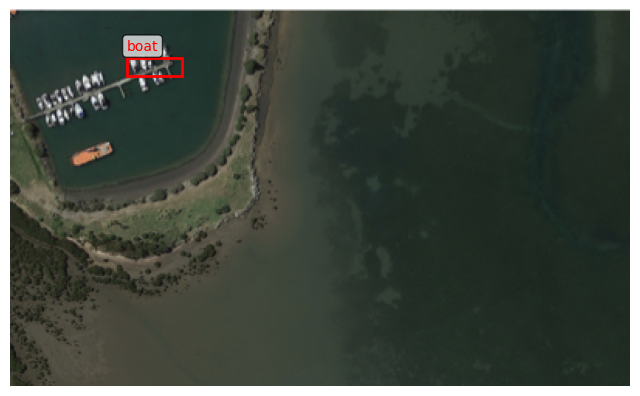

In [50]:
# prediction of the test set
pred_0 = predictions[60]
image_0 = X_test[pred_0["image_id"]]
box_0 = np.array([pred_0["class_id"], pred_0["x_center"], pred_0["y_center"], pred_0["width"], pred_0["height"]]).reshape(1,-1)
print(box.shape)
plot_image_with_boxes(image_0, box_0)

In [21]:
# Save predictions to CSV
df_predictions = pd.DataFrame(predictions)
df_predictions.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")
print("\nFirst few predictions:")
print(df_predictions.head(10))

Predictions saved to predictions.csv

First few predictions:
   image_id  box_idx  class_id  confidence  x_center  y_center     width  \
0         0        0         0    0.812108  0.561425  0.433479  0.123317   
1         0        1         0    0.287426  0.444618  0.488447  0.057466   
2         2        0         0    0.853836  0.482901  0.371589  0.280569   
3         3        0         0    0.849595  0.358734  0.360600  0.122597   
4         4        0         0    0.517523  0.460044  0.399628  0.431318   
5         5        0         0    0.828563  0.443651  0.439663  0.505110   
6         6        0         0    0.833020  0.604353  0.556635  0.500950   
7         7        0         0    0.672969  0.484996  0.364618  0.400393   
8         7        1         0    0.262008  0.531708  0.398144  0.315659   
9         7        2         0    0.261989  0.415874  0.300263  0.391649   

     height  
0  0.152426  
1  0.045982  
2  0.407586  
3  0.228002  
4  0.115868  
5  0.387424  
6  0